# 実践コンピュータビジョン
# 1章 基本的な画像処理

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

## 1.3 NumPy
テキストp.8
### 1.3.1 配列による画像表現

In [46]:
# RGBカラー画像はuint8型の３次元配列になる
im = np.array(Image.open('data/empire.jpg'))
print(im.shape)
print(im.dtype)

(800, 569, 3)
uint8


In [47]:
# 白黒画像はunit8型の２次元配列になる
im = np.array(Image.open('data/empire.jpg').convert('L'))
print(im.shape)
print(im.dtype)

(800, 569)
uint8


In [48]:
# 白黒画像を'f'で指定して、numpy.arrayにするとfloat型のデータになる
im = np.array(Image.open('data/empire.jpg').convert('L'),'f')
print(im.shape)
print(im.dtype)

(800, 569)
float32


テキストではNumPyの行列操作をいくつか紹介しているが、ここでは省略する。  
NumPyの詳細については、Travis Oliphantの"Guide to NumPy"を参照。  
[1] Travis Oliphant, "Guide to NumPy" 1st ed. (2006)   
    http://web.mit.edu/dvp/Public/numpybook.pdf  
[2] Travis Oliphant, "Guide to NumPy" 2nd ed. (2015)   
    https://www.amazon.com/Guide-NumPy-Travis-Oliphant-PhD/dp/151730007X

### 1.3.2 グレーレベルの変換
テキストP.9<br>
画像のグレーレベルを変換する。

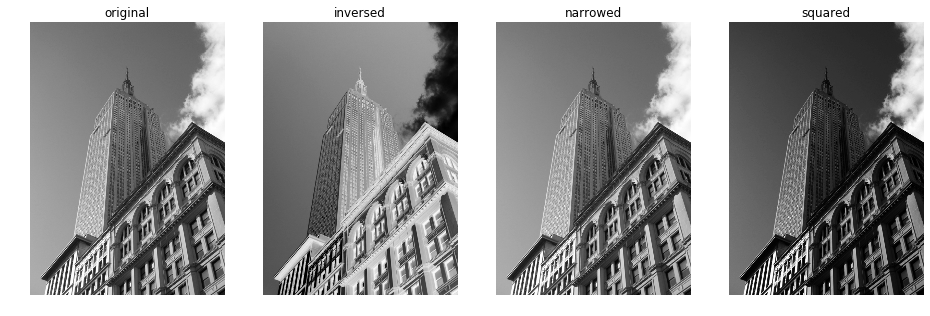

In [49]:
im = np.array(Image.open('data/empire.jpg').convert('L'))
im2 = 255 - im # 画像反転
im3 = (100.0/255) * im + 100 # 100-200の範囲に縮める
im4 = 255.0 * (im/255.0) ** 2 # 2乗する

im_list = [im, im2, im3, im4]
tlist = ['original','inversed','narrowed','squared']
plt.figure(figsize=(16,8))
plt.gray()
for i, im, t in zip(range(4), im_list, tlist):
    plt.subplot(1,4, i+1)
    plt.imshow(im)
    plt.title(t)
    plt.axis('off')

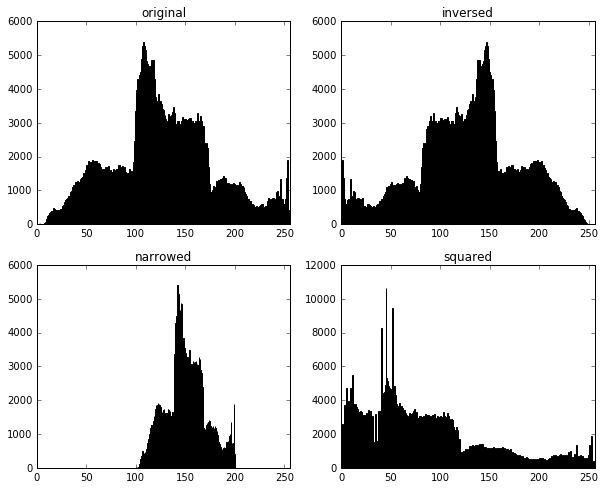

In [50]:
# テキストp.7の例にしたがって、ヒストグラムを書いてみる
plt.figure(figsize=(10,8))
plt.gray()
for i, image, t in zip(range(4), im_list, tlist):
    plt.subplot(2,2, i+1)
    plt.hist(image.flatten(), 256)
    plt.xlim(0,256)
    plt.title(t)

In [51]:
im3.dtype

dtype('float64')

In [52]:
pil_im = Image.fromarray(im)

テキストp.11
> 上記の例のim3やim4のように、「uint8」以外のデータ型に変換した場合には、  
PIL画像を生成する前にデータ型を戻しておく必要があります。

im3の型はfloat64になっているが、Image.fromarray(im3)は有効だった。  
データ型をキャストしてくれているのかもしれない。

In [53]:
# PILデータへの逆変換は有効
pil_im3 = Image.fromarray(im3)
pil_im3.show()

In [54]:
# テキストに従うなら、uint8の型変換を行う。
# uint8はnumpyの関数なので、'np.'を忘れないようにする。
pil_im3 = Image.fromarray(np.uint8(im3))
pil_im3.show()

### 1.3.3 画像のサイズ変更
下記のような画像サイズを変更する関数imresize()を作成して、imtools.pyに追加する。

```python
def imresize(im, sz):
    """ PILを使って画像配列のサイズを変更する"""
    pil_im = Image.fromarray(np.uint8(im))
    return np.array(pil_im.resize(sz))
```

### 1.3.4 ヒストグラム平坦化
Numpyのヒストグラムデータを生成する関数histogramを使って、画像のヒストグラムを作成する。  
参考  
http://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html

下記のとおり、累積分布関数を使うhisteq関数をimtools.pyに追加する

```python
def histeq(im, nbr_bins=256):
    """グレースケール画像のヒストグラム平坦化"""
    # 画像のヒストグラムを得る
    imhist, bins = np.histogram(im.flatten(), nbr_bins, normed=True)
    # 累積分布関数(Cummulated Distributed Function)
    cdf = imhist.cumsum()
    # 正規化
    cdf = 255 + cdf / cdf[-1]
    # cdfを線形補間し、新しいピクセル値とする。
    im2 = np.interp(im.flatten(), bins[:-1], cdf)
    
    return im2.reshape(im.shape), cdf
```

In [55]:
import imtools

In [56]:
im = np.array(Image.open('data/AquaTermi_lowcontrast.jpg').convert('L'))
im2, cdf = imtools.histeq(im)

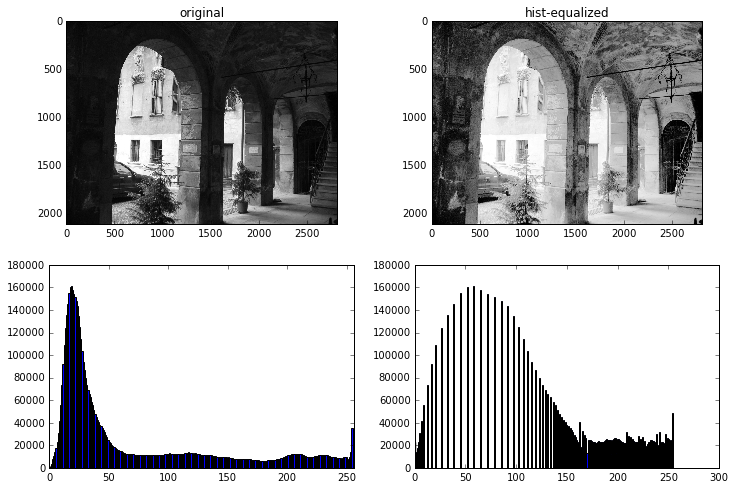

In [57]:
plt.figure(figsize=(12,8))
plt.gray()
plt.subplot(2,2,1)
plt.imshow(im)
plt.title('original')

plt.subplot(2,2,2)
plt.imshow(im2)
plt.title('hist-equalized')

plt.subplot(2,2,3)
plt.hist(im.flatten(),256)
plt.xlim(0,256)

plt.subplot(2,2,4)
plt.hist(im2.flatten(),256)

plt.show()

In [58]:
print('original: min=', im.min(), ', max=', im.max())
print('hist-equalized: min=', im2.min(), ', max=', im2.max())

original: min= 0 , max= 255
hist-equalized: min= 0.0341292452221 , max= 255.0


### 1.3.5 平均画像
テキストp.12  
画像の平均化を行いノイズを低減する

imtools.pyにcompute_average関数を追加する

```python
def compute_average(imlist):
    """画像列の平均を求める"""
    # 最初の画像を開き、浮動小数点数の配列に変換する
    averageim = np.array(Image.open(imlist[0]), 'f')
    
    for imname in imlist[1:]:
        try:
            averageim += np.array(Image.open(imname))
        except:
            print(imname, '...skipped')
    averageim /= len(imlist)

    # 平均をuint8に変換する
    return np.array(averageim, 'uint8')
```

### 1.3.6 画像の主成分分析
numpyのlinalgモジュールを利用して、アルファベットのaの画像データセットについて主成分分析を行う。  

参考  
NumPy Documentation, linalg  
http://docs.scipy.org/doc/numpy/reference/routines.linalg.html

主成分分析を行う関数pcaを作成し、pca.pyに格納する  
```python
def pca(X):
    """主成分分析
        入力： X, 訓練データを平板化した配列を行として格納した行列
        出力： 写像行列（次元の重要度順）、分散、平均"""
    
    # 次元数を取得
    num_data, dim = X.shape
    # データをセンタリング
    mean_X = X.mean(axis=0)
    X = X - mean_X
    
    if dim > num_data:
        # PCA: 高次元のときはコンパクトな裏技を用いる
        M = np.dot(X, X.T) # 共分散行列
        e, EV = np.linalg.eigh(M) # 固有値と固有ベクトル
        tmp = np.dot(X.T, EV).T # ここがコンパクトな裏技
        V = tmp[::-1] # 末尾の固有ベクトルほど重要なので、反転する
        S = np.sqrt(e)[::-1] # 固有値の並びも反転する
        for i in range(V.shape[1]):
            V[:,i] /= S
    else:
        # PCA: 低次元なら特異値分解を用いる
        U,S,V = np.linalg.svd(X)
        V = V[:num_data] # 最初のnum_dataの分だけが有用
    
    # 写像行列と、分散と、平均を返す
    return V, S, mean_X
```

In [59]:
import pca

### Step. 1
2359個のアルファベットの画像データセットを読み込む。  

In [60]:
# アルファベットの文字画像のファイルリストを読み込む
imlist = imtools.get_imlist('a_thumbs')
imnbr = len(imlist)
print(imnbr)

2359


In [61]:
# １つ目のファイルを開く
im = np.array(Image.open(imlist[0]))
# 画像のサイズを記録しておく
m, n = im.shape[0:2]
print(m,n)

25 25


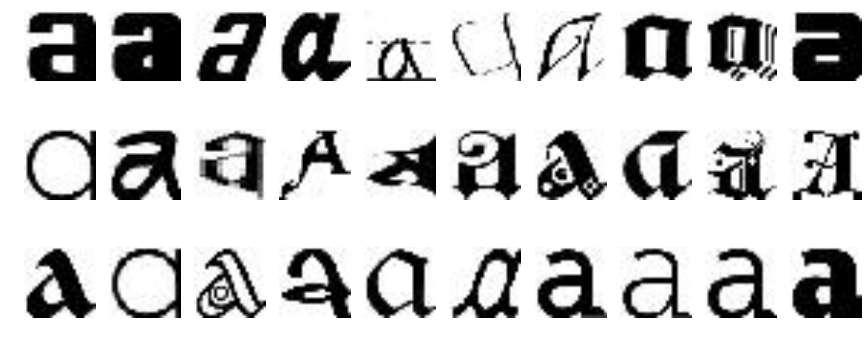

In [62]:
# 最初の３０個のアルファベット画像を表示する
plt.figure(figsize=(15,6))
for i, im in enumerate(imlist[:30]):
    im = np.array(Image.open(im))
    plt.subplot(3,10,i+1)
    plt.imshow(im)
    plt.axis('off')
plt.show()

### Step. 2
アルファベット画像の行列を１次元配列に直し（平板化）、主成分分析を行う。

In [63]:
# すべての平板化画像を格納する行列を作る
immatrix = np.array([np.array(Image.open(im)).flatten()
                     for im in imlist], 'f')

In [64]:
# 主成分分析を実行する
V, S, immean = pca.pca(immatrix)

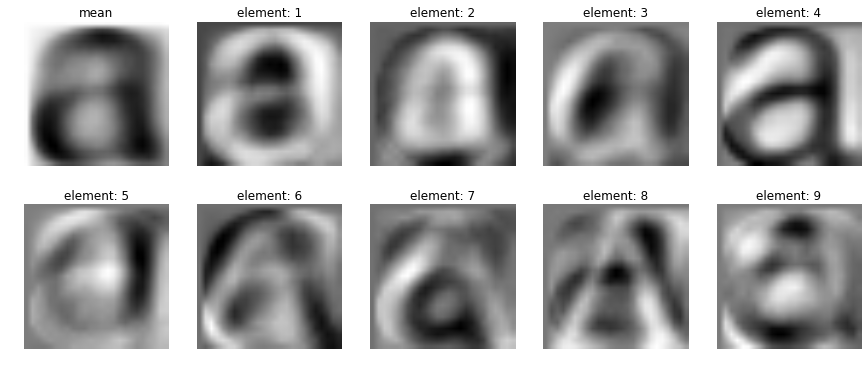

In [65]:
# 画像を表示する（平均と、最初の7つの主成分）
plt.figure(figsize=(15,6))
plt.gray()
plt.subplot(2,5,1)
plt.imshow(immean.reshape(m,n))
plt.axis('off')
plt.title('mean')
for i in range(9):
    plt.subplot(2,5, i+2)
    plt.imshow(V[i].reshape(m,n))
    plt.axis('off')
    cap = 'element: ' + str(i+1) 
    plt.title(cap)
plt.show()

### 1.3.7 pickleモジュール
pickleモジュールを使って、処理結果の書き出し（dump）と読み込み（load）を行う。

In [66]:
import pickle

# 平均と主成分を書き込む
with open('font_pca_modes.pkl', 'wb') as f:
    pickle.dump(immean,f) 
    pickle.dump(V,f) 

In [67]:
# 平均と主成分を読み出す
with open('font_pca_modes.pkl', 'rb') as f:
    immean2 = pickle.load(f) 
    V2 = pickle.load(f)

In [68]:
# 正しく記録できたことを確認する
print(immean[:5])
print(immean2[:5])

[ 252.89233398  251.9122467   252.43746948  252.0038147   251.92666626]
[ 252.89233398  251.9122467   252.43746948  252.0038147   251.92666626]


In [69]:
# 正しく記録できたことを確認する
print(V[0].shape)
print(V2[0].shape)

(625,)
(625,)
